# Example: polydisperse spheres with a challenging size distribution

In this notebook, we try to recover a challenging size distribution of polydisperse spheres using `ffsas`. This example also shows the non-uniqueness of solutions in SAS inversion by using different resolutions (bin numbers) for the radius axis. We also solve this problem with `Irena` and `McSAS` for comparison.

This notebook uses the [SASView/SASModels](http://www.sasview.org/docs/user/models/sphere.html) unit system.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import torch

from ffsas.models import Sphere
from ffsas.system import SASGreensSystem

# avoid an OMP error on MacOS (nothing to do with ffsas)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# reproduce figures in the paper 
reproduce_paper_fig = True
if reproduce_paper_fig:
    # this will trigger an error if latex is not installed
    plt.rcParams.update({
        "text.usetex": True,
        "text.latex.preamble": r'\usepackage{bm,upgreek}',
        "font.family": "sans-serif",
        "font.serif": ["Times"]})
    # figure dir
    paper_fig_dir = Path('../paper_figs')
    Path(paper_fig_dir).mkdir(parents=True, exist_ok=True)

# Ground truth


### Ground truth of radius distribution

The following function creates a "crazy" radius distribution by adding up a few Gaussians and random noises.

In [3]:
def crazy_distribution(x, gaussians, noise_level, fade_start, fade_end, seed=0):
    # create
    w_true = torch.zeros(x.shape)
    
    # add Gaussians
    for factor, mean, stddev in gaussians:
        w_true += factor * torch.exp(-((x - mean) / stddev) ** 2)
    
    # add noise
    torch.random.manual_seed(seed)
    w_true += noise_level * torch.rand(x.shape) * torch.rand(x.shape)
    
    # fade both ends to make it look nicer
    w_true[0:fade_start] = 0.
    w_true[fade_start:fade_end] *= torch.linspace(0, 1, fade_end - fade_start)
    w_true[-fade_start:] = 0.
    w_true[-fade_end:-fade_start] *= torch.linspace(1, 0, fade_end - fade_start)
    
    # normalize to 1
    w_true /= torch.sum(w_true)
    return w_true

Make a challenging radius distribution using the above function:

In [4]:
# radius vector
r = torch.linspace(500., 1000., 300)

# Make a crazy radius distribution with Gaussian and random
w_true = crazy_distribution(r, [(4, 580, 10), (6, 630, 20), (10, 700, 20), 
                                (12, 750, 20), (8, 850, 15), (5, 930, 15)],
                            noise_level=10, fade_start=10, fade_end=40)

### Ground truth of intensity

Now, based on the above radius distribution, we compute the ground truth of intensity. 

Note that the parameter `scale` in [SASView/SASModels](http://www.sasview.org/docs/user/models/sphere.html) is not the $\xi$ in `ffsas`. For the particular unit system of [SASView/SASModels](http://www.sasview.org/docs/user/models/sphere.html), the relation between `scale` and $\xi$ is

$$\xi=10^{-4}\times\dfrac{\mathrm{scale}}{V_\text{ave}},$$

where $10^{-4}$ comes from the unit system and $V_\text{ave}$ is the average volume. The `background` in [SASView/SASModels](http://www.sasview.org/docs/user/models/sphere.html) has the same definition as $b$ in `ffsas`.

In [5]:
# ground truth of scale and background
scale_true = 2.5
b_true = .14

# q vector
q = 10 ** torch.linspace(-3, 0, 4000)

# (SLD - SLD_solvent) ^ 2
drho = 25.

# compute the Green's tensor
G = Sphere.compute_G_mini_batch([q], {'r': r}, {'drho': drho})

# compute the ground truth of xi
V = Sphere.compute_V({'r': r})
V_ave = torch.dot(V, w_true)
xi_true = 1e-4 * scale_true / V_ave

# define the G-based SAS system
g_sys = SASGreensSystem(G, Sphere.get_par_keys_G(), log_screen=True)

# finally compute the ground truth of intensity
I_true = g_sys.compute_intensity({'r': w_true}, xi_true, b_true)

# we do not have sigma of data, so we use mu * uncertainty_ratio as sigma
uncertainty_ratio = 1.
I_true_std = I_true * uncertainty_ratio

# save intensity data
np.savetxt('observation.txt', 
           torch.stack([q, I_true, I_true_std]).t().numpy())

# McSAS use nm^-1 for q
np.savetxt('mcsas/observation_McSAS.txt', 
           torch.stack([q * 10, I_true, I_true_std]).t().numpy())

<BEGIN> Computing the Green's tensor G
....<MESSG> Class name = Sphere
....<BEGIN> Checking tensor dtypes
........<MESSG> torch dtype = torch.float64
....<ENDED> Checking tensor dtypes [ELAPSED = 0.000698 sec]
....<BEGIN> Computing volume V
....<ENDED> Computing volume V [ELAPSED = 0.000256 sec]
....<BEGIN> Handling fixed parameters
........<MESSG> model parameters = ['r']
........<MESSG> fixed parameters = []
........<MESSG> free parameters = ['r']
....<ENDED> Handling fixed parameters [ELAPSED = 0.001985 sec]
....<BEGIN> Creating space for G
........<MESSG> G shape = [4000, 300]
........<MESSG> G count = 1200000
........<MESSG> G size (MB) = 9.6
........<MESSG> G stored in memory
....<ENDED> Creating space for G [ELAPSED = 0.003548 sec]
....<BEGIN> Sending parameters and constants to device
........<MESSG> device = cpu
....<ENDED> Sending parameters and constants to device [ELAPSED = 0.001145 sec]
....<BEGIN> Creating batch indices
........<MESSG> batch size = 4000
........<MESSG> ba

Plot the ground truth:

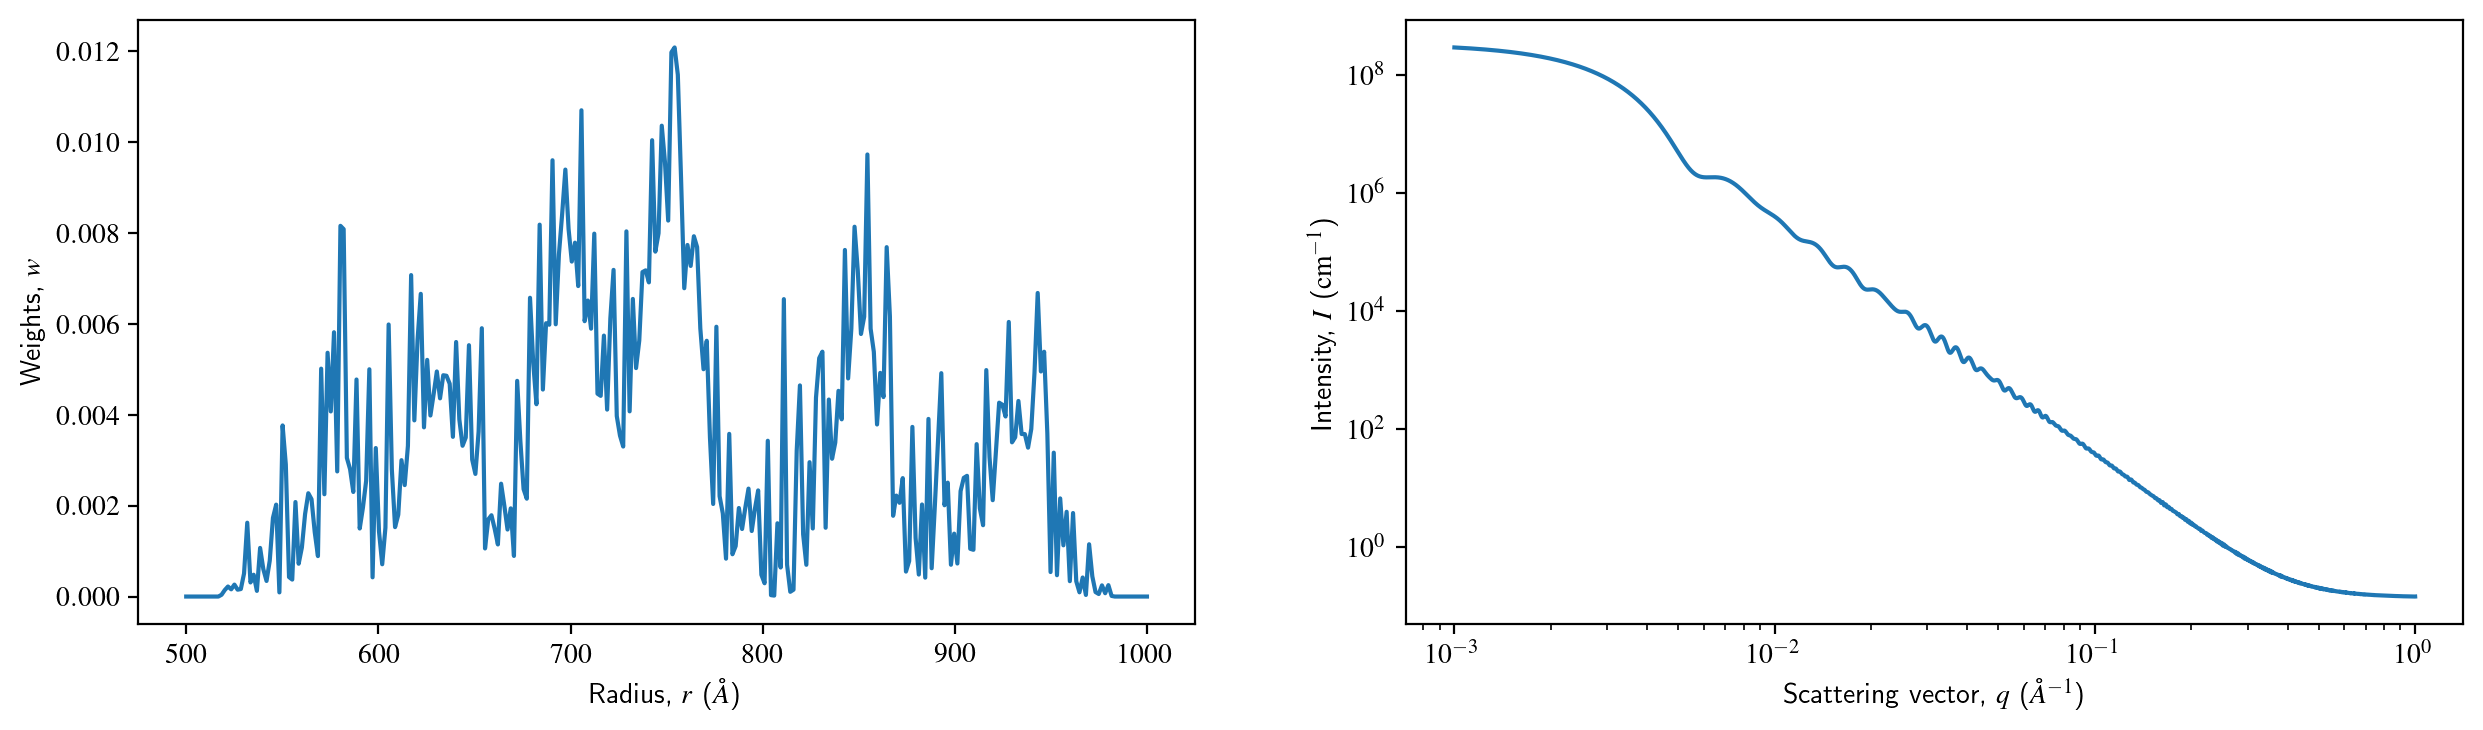

In [6]:
fig, ax = plt.subplots(dpi=200, ncols=2, figsize=(15, 4))
ax[0].plot(r, w_true)
ax[0].set_xlabel(r'Radius, $r$ ($\AA$)')
ax[0].set_ylabel(r'Weights, $w$')
ax[1].plot(q, I_true)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'Scattering vector, $q$ ($\AA^{-1}$)')
ax[1].set_ylabel(r'Intensity, $I$ ($\mathrm{cm}^{-1}$)')
plt.show()

Upsample true weights to the highest resolution for accuracy evaluation and visualization:

In [7]:
high_reso = 400
r_high = torch.linspace(r[0], r[-1], high_reso)
w_true_high = torch.tensor(interpolate.interp1d(r, w_true)(r_high))
w_true_high /= torch.sum(w_true_high)

---

#  Inversion

Now we solve the inverse problem at different radius resolutions. It is expected that we "exactly" reproduce the ground truth with the resolution it was created, or 300 (`r = torch.linspace(500., 1000., 300)`).

In [17]:
# solve at four resolutions
resolutions = [100, 200, 300, 400]
results = []

# loop over resolutions
for reso in resolutions:
    # resampled r vector at given resolution
    r_reso = torch.linspace(r[0], r[-1], reso)
    
    # recompute G
    G_reso = Sphere.compute_G_mini_batch([q], {'r': r_reso}, {'drho': drho}, log_screen=False)
    
    # define the system
    g_sys_reso = SASGreensSystem(G_reso, par_keys=Sphere.get_par_keys_G())
    
    # solve the inverse problem using "true" intensity
    result_dict = g_sys_reso.solve_inverse(I_true, I_true_std, 
                                           auto_scaling=True, maxiter=1000, verbose=1)
    
    # get weights from result dict
    w_reso = result_dict['w_dict']['r']
    std_w_reso = result_dict['std_w_dict']['r']
    
    # upsample w to high resolution so we can plot them together
    w_high = torch.tensor(interpolate.interp1d(r_reso, w_reso)(r_high))
    std_w_high = torch.tensor(interpolate.interp1d(r_reso, std_w_reso)(r_high))
    norm = torch.sum(w_high)
    w_high /= norm
    std_w_high /= norm
    
    # compute scale 
    scale = result_dict['xi'] * V_ave / 1e-4
    results.append((reso, w_reso, w_high, std_w_high, scale, result_dict['xi'], result_dict['b'], 
                    result_dict['I'], result_dict['wct']))

<BEGIN> Initializing SASGreensSystem object
....<BEGIN> Determining dimensions
........<MESSG> q dimensions = [4000]
........<MESSG> w dimensions = [100]
........<MESSG> parameter keys = ['r']
........<MESSG> torch dtype = torch.float64
....<ENDED> Determining dimensions [ELAPSED = 0.003852 sec]
....<BEGIN> Resolving space for G
........<MESSG> G stored in memory
........<MESSG> G shape = torch.Size([4000, 100])
........<MESSG> G count = 400000
........<MESSG> G size (MB) = 3.2
....<ENDED> Resolving space for G [ELAPSED = 0.005502 sec]
....<BEGIN> Configuring batch and device
........<MESSG> batch size = 4000
........<MESSG> batch count = 1
........<MESSG> computing device = cpu
....<ENDED> Configuring batch and device [ELAPSED = 0.004460 sec]
<ENDED> Initializing SASGreensSystem object [ELAPSED = 0.019798 sec]
<BEGIN> Solving inverse problem NLP-s
....<BEGIN> Data processing
........<BEGIN> Computing nu, d/nu and mu/nu
............<MESSG> using nu=mu^0.0*sigma^1.0
........<ENDED> Comp

........<ENDED> Unpacking results [ELAPSED = 0.309468 sec]
....<ENDED> Solving NLP-s by trust-region [ELAPSED = 13.129799 sec]
<ENDED> Solving inverse problem NLP-s [ELAPSED = 13.155732 sec]
<BEGIN> Initializing SASGreensSystem object
....<BEGIN> Determining dimensions
........<MESSG> q dimensions = [4000]
........<MESSG> w dimensions = [400]
........<MESSG> parameter keys = ['r']
........<MESSG> torch dtype = torch.float64
....<ENDED> Determining dimensions [ELAPSED = 0.003366 sec]
....<BEGIN> Resolving space for G
........<MESSG> G stored in memory
........<MESSG> G shape = torch.Size([4000, 400])
........<MESSG> G count = 1600000
........<MESSG> G size (MB) = 12.8
....<ENDED> Resolving space for G [ELAPSED = 0.002744 sec]
....<BEGIN> Configuring batch and device
........<MESSG> batch size = 4000
........<MESSG> batch count = 1
........<MESSG> computing device = cpu
....<ENDED> Configuring batch and device [ELAPSED = 0.001894 sec]
<ENDED> Initializing SASGreensSystem object [ELAPSED 

Finally, plot the results at the different resolutions as well as the results from `Irena` and `McSAS`:

In [18]:
# plot options
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'axes.titlesize': 22})
plt.rcParams.update({'lines.linewidth': 2})

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
c_data = colors[0]
c_ffsas = colors[1]
c_irena = colors[3]
c_mcsas = colors[6]

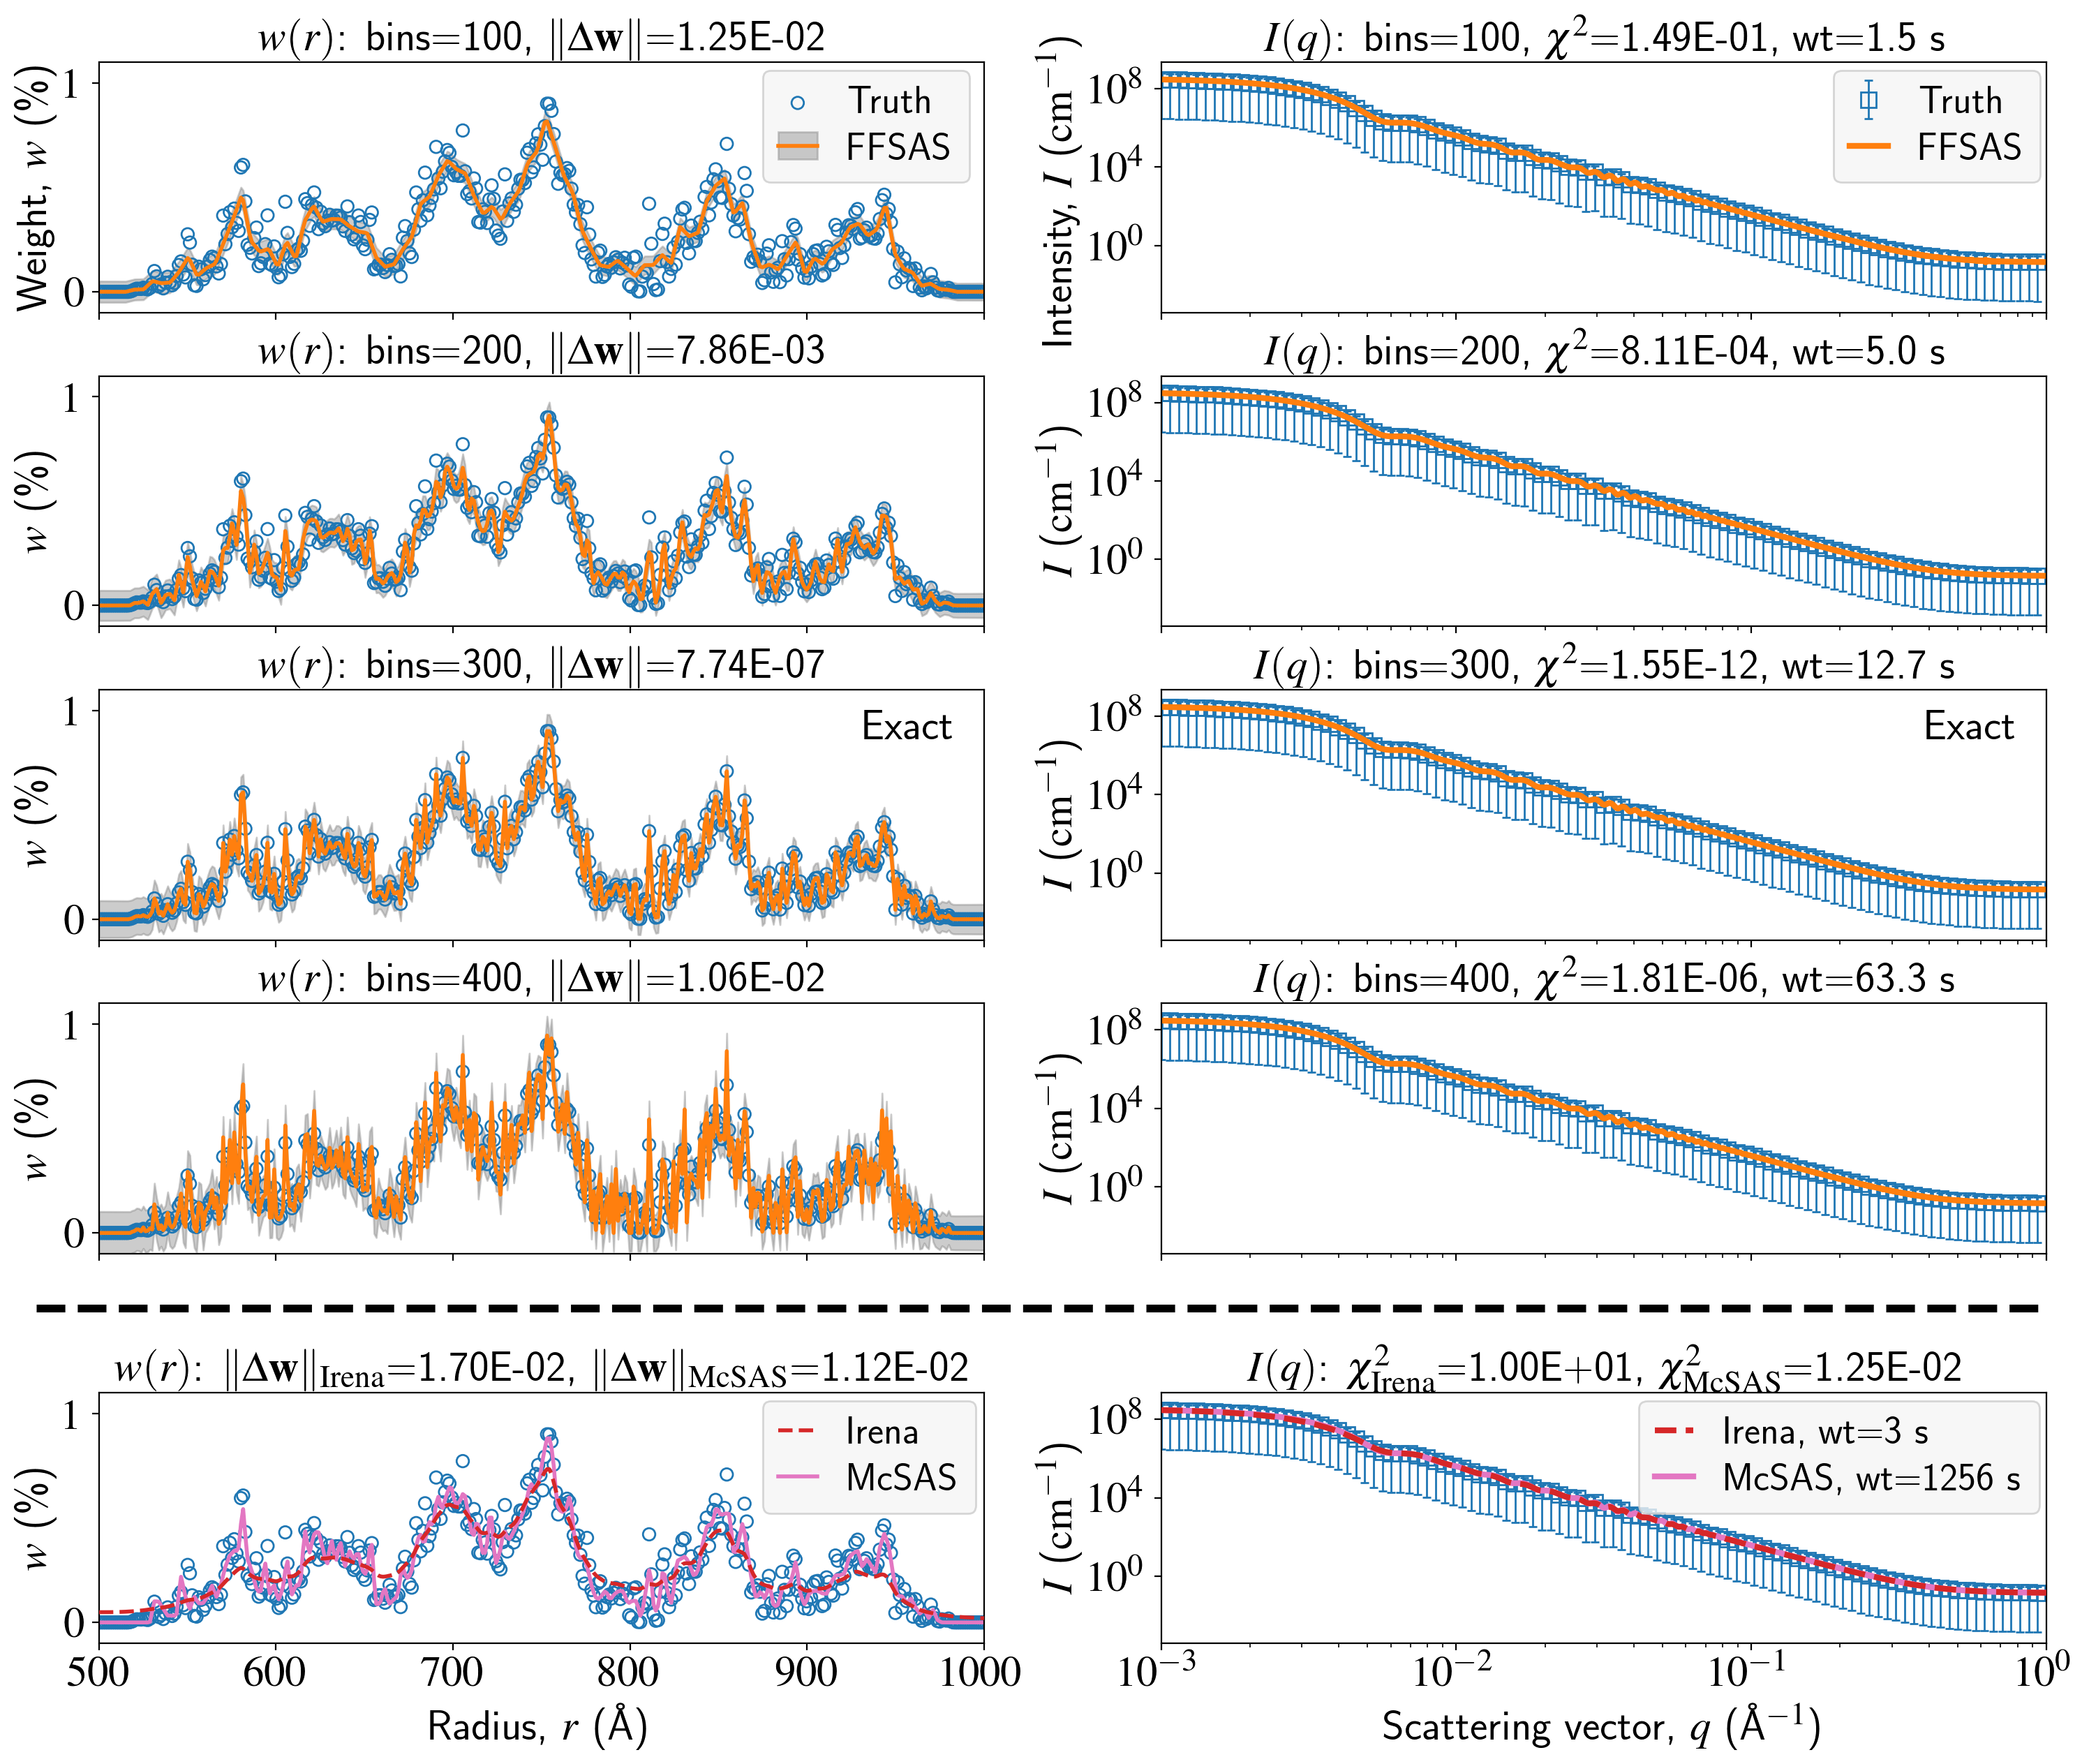

In [19]:
fig, ax = plt.subplots(nrows=len(results) + 2, ncols=2, dpi=200, 
                       figsize=(18, (len(results) + 1) * 3), squeeze=False,
                       gridspec_kw={'height_ratios': [1] * len(results) + [.05, 1]})
plt.subplots_adjust(hspace=.3)
for i, (reso, w_reso, w_high, std_w_high, scale, xi, b, I, wct) in enumerate(results):
    #######################
    # radius distribution #
    #######################
    # truth
    plot_true = ax[i][0].scatter(r_high, w_true_high * 100, lw=1, 
                                 facecolors='none', edgecolor=c_data, s=40)
    # inverted
    plot_fit = ax[i][0].plot(r_high, w_high * 100, c=c_ffsas)
    plot_err = ax[i][0].fill_between(r_high, (w_high - std_w_high) * 100, (w_high + std_w_high) * 100, 
                                     alpha=.4, color='gray', zorder=-100)
    dw_norm = torch.norm(w_true_high - w_high)
    ax[i][0].set_title(r'$w(r)$: bins=%d, $\|\Delta\mathbf{w}\|$=%.2E' % (
        reso, dw_norm))
    ax[i][0].set_ylim(-0.1, 1.1)
    ax[i][0].set_ylabel(r'$w$ (\%)')
    ax[0][0].set_ylabel(r'Weight, $w$ (\%)')
    ax[i][0].set_xticklabels([])
    ax[i][0].set_xlim(500, 1000)
    
    #####################
    # intensity fitting #
    #####################
    # truth
    st = 40
    ax[i][1].errorbar(q[::st], I_true[::st], I_true[::st] / 1.01, 
                      markerfacecolor='none', markeredgecolor=c_data, ecolor=c_data, fmt='s',  
                      markersize=8, capsize=2, lw=1,
                      zorder=-10, label='Truth')
    # fitted
    ax[i][1].plot(q, I, c=c_ffsas, label='FFSAS', lw=3)
    chi2 = torch.norm((I_true - I) / I_true_std) ** 2
    ax[i][1].set_title(r'$I(q)$: bins=%d, $\chi^2$=%.2E, wt=%.1f s' % (
        reso, chi2, wct))
    ax[i][1].set_xscale('log')
    ax[i][1].set_yscale('log')
    ax[i][1].set_ylabel(r'$I$ ($\mathrm{cm}^{-1}$)')
    ax[0][1].set_ylabel(r'Intensity, $I$ ($\mathrm{cm}^{-1}$)')
    ax[i][1].set_xticklabels([])
    ax[i][1].set_yticks([1, 1e4, 1e8])
    ax[i][1].set_xlim(1e-3, 1)
    
    # add some text
    if reso == 300:
        ax[i][0].text(.97, .92, 'Exact', transform=ax[i][0].transAxes, 
                     ha='right', va='top', fontsize=22, color='k')
        ax[i][1].text(.97, .92, 'Exact', transform=ax[i][1].transAxes, 
                     ha='right', va='top', fontsize=22, color='k')

# legend
ax[0][0].legend([plot_true, (plot_err, plot_fit[0])],
                ['Truth', 'FFSAS'],
                loc=(.75, .52), handlelength=1, facecolor='whitesmoke', labelspacing=.3)
handles, labels = ax[0][1].get_legend_handles_labels()
ax[0][1].legend([handles[idx] for idx in [1, 0]], [labels[idx] for idx in [1, 0]], 
                loc=(.76, .52), handlelength=1, facecolor='whitesmoke', labelspacing=.3)

# sep
ax[-2][0].axis('off')
ax[-2][1].axis('off')
line = plt.Line2D([.10, .9], [.285, .285], c='k', ls='--', lw=4, 
                  transform=fig.transFigure)
fig.lines.append(line)


###########################
# intensity Irena & McSAS #
###########################
# Irena
vol_frac = np.loadtxt('irena/output_wv(r).txt')[150:450]
w_irena = vol_frac / r ** 3
w_irena = interpolate.interp1d(r, w_irena, fill_value="extrapolate")(r_high)
w_irena /= w_irena.sum()
dw_norm_irena = torch.norm(w_true_high - w_irena)

# McSAS
mcsas_data = np.loadtxt('mcsas/output_w(r).dat', skiprows=1)
r_low = mcsas_data[:, 0] * 1e10
w_low = mcsas_data[:, 2]
w_mcsas = interpolate.interp1d(r_low, w_low, fill_value="extrapolate")(r_high)
w_mcsas /= w_mcsas.sum()
dw_norm_mcsas = torch.norm(w_true_high - w_mcsas)

# plot
ax[-1][0].scatter(r_high, w_true_high * 100, lw=1, 
                  facecolors='none', edgecolor=c_data, s=40, label='Truth')
ax[-1][0].plot(r_high, w_irena * 100, c=c_irena, ls='--', zorder=100, label='Irena')
ax[-1][0].plot(r_high, w_mcsas * 100, c=c_mcsas, label='McSAS')
ax[-1][0].set_title(r'$w(r)$: $\|\Delta\mathbf{w}\|_\mathrm{Irena}$=%.2E, '
                    r'$\|\Delta\mathbf{w}\|_\mathrm{McSAS}$=%.2E' % (dw_norm_irena, dw_norm_mcsas))
ax[-1][0].set_ylim(-0.1, 1.1)
ax[-1][0].set_xlim(500, 1000)
ax[-1][0].set_ylabel(r'$w$ (\%)')
ax[-1][0].set_xlabel(r'Radius, $r$ (\AA)')
handles, labels = ax[-1][0].get_legend_handles_labels()
ax[-1][0].legend([handles[idx] for idx in [0, 1]], [labels[idx] for idx in [0, 1]], 
                 loc=(.75, .52), handlelength=1, facecolor='whitesmoke', labelspacing=.3)

###########################
# intensity Irena & McSAS #
###########################
# Irena
I_irena = np.loadtxt('irena/output_I(q).txt')
I_irena += b_true  # Irena saves data without background
chi2_irena = torch.norm((I_true - I_irena) / I_true_std) ** 2
wct_irena = 3.5

# McSAS
mc_data = np.loadtxt('mcsas/output_I(q).dat', skiprows=1)
q_low = mc_data[:, 0] / 1e10
I_low = mc_data[:, 3]
I_mcsas = interpolate.interp1d(q_low, I_low, fill_value="extrapolate")(q)
chi2_mcsas = torch.norm((I_true - I_mcsas) / I_true_std) ** 2
wct_mcsas_min = 20.9399139841

# plot
ax[-1][1].errorbar(q[::st], I_true[::st], I_true[::st] / 1.01, 
                   markerfacecolor='none', markeredgecolor=c_data, ecolor=c_data, fmt='s',  
                   markersize=8, capsize=2, lw=1,
                   zorder=-10, label='Truth')
ax[-1][1].plot(q, I_irena, c=c_irena, lw=3, ls='--', zorder=5, label='Irena, wt=3 s')
ax[-1][1].plot(q, I_mcsas, c=c_mcsas, lw=3, label='McSAS, wt=%d s' % (wct_mcsas_min * 60))
ax[-1][1].set_title(r'$I(q)$: $\chi^2_\mathrm{Irena}$=%.2E, '
                    r'$\chi^2_\mathrm{McSAS}$=%.2E' % (chi2_irena, chi2_mcsas))
ax[-1][1].set_xscale('log')
ax[-1][1].set_yscale('log')
ax[-1][1].set_yticks([1, 1e4, 1e8])
ax[-1][1].set_xlim(1e-3, 1)
ax[-1][1].set_ylabel(r'$I$ ($\mathrm{cm}^{-1}$)')
ax[-1][1].set_xlabel(r'Scattering vector, $q$ (\AA$^{-1}$)')
handles, labels = ax[-1][1].get_legend_handles_labels()
ax[-1][1].legend([handles[idx] for idx in [0, 1]], [labels[idx] for idx in [0, 1]], 
                 loc=(.54, .52), handlelength=1, facecolor='whitesmoke', labelspacing=.3)

# save figure for paper 
if reproduce_paper_fig:
    plt.savefig(paper_fig_dir / 'sphere.pdf', 
                bbox_inches='tight', facecolor='w', pad_inches=.1)
plt.show()

---